## An example of custom local SHC model evaluation

In [89]:
# load data

from viresclient import SwarmRequest
from viresclient._wps.time_util import parse_datetime
import datetime as dt
import numpy as np
import pandas as pd

request = SwarmRequest("https://staging.viresdisc.vires.services/openows")

request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=['B_NEC'],
    auxiliaries=['QDLat'],
    sampling_step="PT1S" 
)
data = request.get_between(
    start_time="2014-01-01T00:00:00Z",
    end_time="2014-01-02T00:00:00Z"
).as_xarray()


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (5.621MB)


In [90]:
# extrat times and coordinates

NS2DAYS = 1.0/(24*60*60*1e9)

# time as MJD2000
times = (
    np.asarray(data["Timestamp"], dtype="M8[ns]") - np.datetime64('2000')
).astype('int64') * NS2DAYS

# spherical coordinates
coords = np.stack((
    np.asarray(data["Latitude"]), # latitude in deg
    np.asarray(data["Longitude"]), # latitude in deg
    np.asarray(data["Radius"])*1e-3, # radius in km
), axis=1)

# measurement
b_nec_measured = np.asarray(data["B_NEC"])

# qdlatitudes
qdlats = np.asarray(data["QDLat"])

In [95]:
# load model and evaluate the model

from eoxmagmod import load_model_shc
from eoxmagmod.data import CHAOS6_CORE_LATEST as CUSTOM_SHC_FILE

custom_model = load_model_shc(CUSTOM_SHC_FILE)

b_nec_model = custom_model.eval(times, coords, scale=[1, 1, -1]) # note the reversed radial component

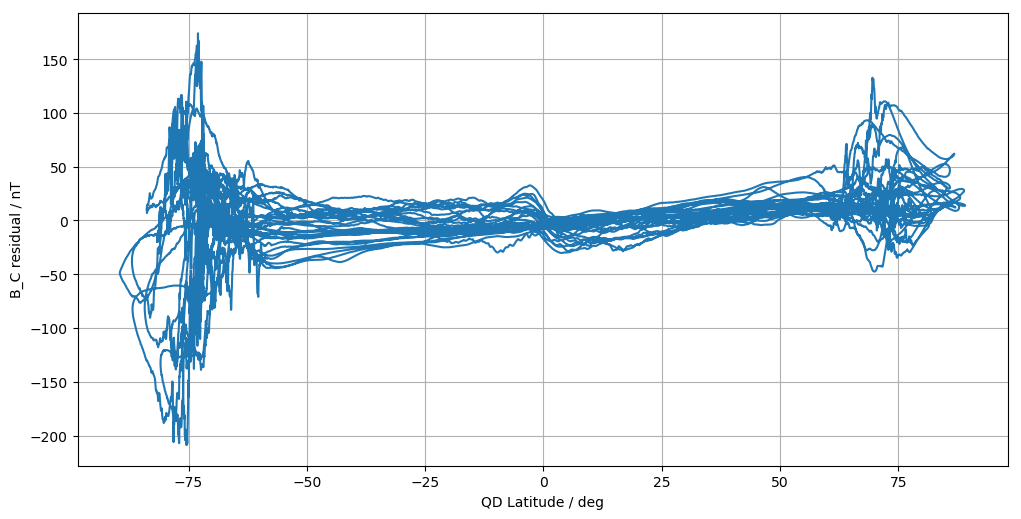

In [112]:
from matplotlib import pyplot as plt

b_nec_res = b_nec_measured - b_nec_model

fig=plt.figure(figsize=(12, 6), dpi= 100, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.plot(qdlats, b_nec_res[..., 2])
ax.grid()
ax.set_xlabel('QD Latitude / deg')
ax.set_ylabel('B_C residual / nT')
pass